<a href="https://colab.research.google.com/github/JoelAbadi/DI-Bootcamp/blob/main/W8_D5_XP_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
# TODO : import the dataset

from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("AB_Test_Results.csv")  # Update the name if your file is different




Saving AB_Test_Results.csv to AB_Test_Results.csv


In [3]:
# TODO : take a quick look at the data

df.head()


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Let's see if there are users who have two A/B test groups

In [4]:
# TODO : Look at the distribution of the number of unique groups for each user

df.groupby("USER_ID")["VARIANT_NAME"].nunique().value_counts()



,count
VARIANT_NAME,
1,4783
2,1541


In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms

df.groupby("USER_ID")["VARIANT_NAME"].nunique().value_counts(normalize=True)


,proportion
VARIANT_NAME,
1,0.756325
2,0.243675


What can you observe ? Should we exclude these users ? Why ?

In [ ]:
# TODO : users have 1 A/B test group ?

# TODO : Take only these users

valid_users = df.groupby("USER_ID")["VARIANT_NAME"].nunique()
df = df[df["USER_ID"].isin(valid_users[valid_users == 1].index)]



In [ ]:
# TODO : Leave only records with users with the 1st ab test group

# TODO : Check that the number of users matches what it was before the exception

# Already filtered above; we now check user count matches
print("Number of unique users after filtering:", df["USER_ID"].nunique())


Number of unique users after filtering: 4783


Let's see how the data is distributed

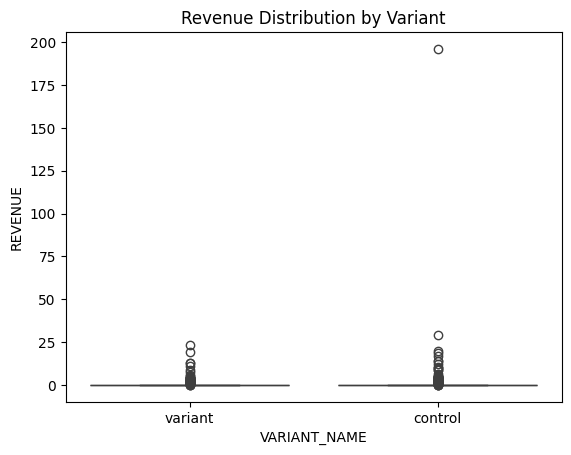

In [ ]:
# TODO : Check how the data is distributed using a box plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title("Revenue Distribution by Variant")
plt.show()



It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [ ]:
# TODO : Sort these revenue values in descending order

df.sort_values(by="REVENUE", ascending=False).head()


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [ ]:
# TODO : See if user 3342 had other events with a strong outlier

df[df["USER_ID"] == 3342]


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

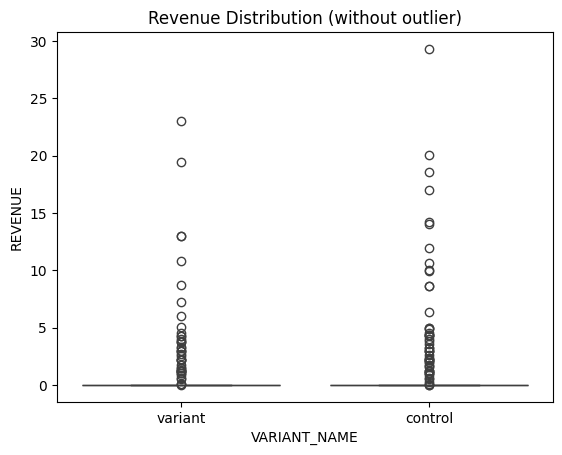

In [ ]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.

df = df[df["USER_ID"] != 3342]  # Remove the outlier
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title("Revenue Distribution (without outlier)")
plt.show()



What can you say about the users and their purchases ?

In [ ]:
# TODO : Check if there are users who have records with zero and positive revenue

mixed_revenue_users = df.groupby("USER_ID")["REVENUE"].apply(lambda x: (x > 0).any() and (x == 0).any())


df[df["USER_ID"].isin(mixed_revenue_users[mixed_revenue_users].index)]


,USER_ID,VARIANT_NAME,REVENUE
19,8927,variant,0.00
49,6429,control,3.25
110,6207,control,0.00
139,3331,variant,4.27
204,443,variant,0.00
...,...,...,...
9417,6429,control,0.00
9612,1035,control,0.23
9651,9928,variant,1.25
9758,708,variant,0.00


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [ ]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user

df = df.groupby(["USER_ID", "VARIANT_NAME"])["REVENUE"].sum().reset_index()


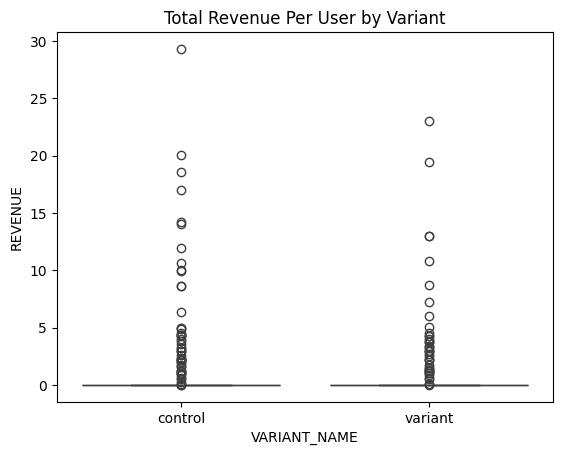

In [ ]:
# TODO : Visualize the resulting distribution of the data again.

sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title("Total Revenue Per User by Variant")
plt.show()


It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [ ]:
# TODO : get metrics by groups

group_stats = df.groupby("VARIANT_NAME").agg(
    total_users=('USER_ID', 'count'),
    total_revenue=('REVENUE', 'sum'),
    avg_revenue=('REVENUE', 'mean'),
    median_revenue=('REVENUE', 'median'),
    std_revenue=('REVENUE', 'std')
).reset_index()

# TODO : create two additional metrics to see relative changes
control_revenue = group_stats[group_stats['VARIANT_NAME'] == 'control']['total_revenue'].iloc[0]
variant_revenue = group_stats[group_stats['VARIANT_NAME'] == 'variant']['total_revenue'].iloc[0]
revenue_relative_change = (variant_revenue - control_revenue) / control_revenue * 100

control_avg_revenue = group_stats[group_stats['VARIANT_NAME'] == 'control']['avg_revenue'].iloc[0]
variant_avg_revenue = group_stats[group_stats['VARIANT_NAME'] == 'variant']['avg_revenue'].iloc[0]
avg_revenue_relative_change = (variant_avg_revenue - control_avg_revenue) / control_avg_revenue * 100


# TODO : add them to the rest of the metrics in a separate group
additional_metrics = pd.DataFrame({
    'Metric': ['Total Revenue Relative Change (%)', 'Average Revenue Relative Change (%)'],
    'Value': [revenue_relative_change, avg_revenue_relative_change]
})

print("Group Statistics:")
display(group_stats)
print("\nAdditional Metrics (Relative Change):")
display(additional_metrics)

Group Statistics:


,VARIANT_NAME,total_users,total_revenue,avg_revenue,median_revenue,std_revenue
0,control,2389,274.55,0.114923,0.0,1.162495
1,variant,2393,179.32,0.074935,0.0,0.858207



Additional Metrics (Relative Change):


,Metric,Value
0,Total Revenue Relative Change (%),-34.685850
1,Average Revenue Relative Change (%),-34.795025


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [ ]:
# TODO : get metrics by groups


# TODO : create two additional metrics to see relative changes


# TODO : add them to the rest of the metrics in a separate group


Paying User Group Statistics:


,VARIANT_NAME,total_users,total_revenue,avg_revenue,median_revenue,std_revenue
0,control,53,274.55,5.180189,2.99,5.942771
1,variant,42,179.32,4.269524,2.97,4.962253



Paying User Additional Metrics (Relative Change):


,Metric,Value
0,Paying User Total Revenue Relative Change (%),-34.685850
1,Paying User Average Revenue Relative Change (%),-17.579763


Let's look at the distributions of all and only paying users

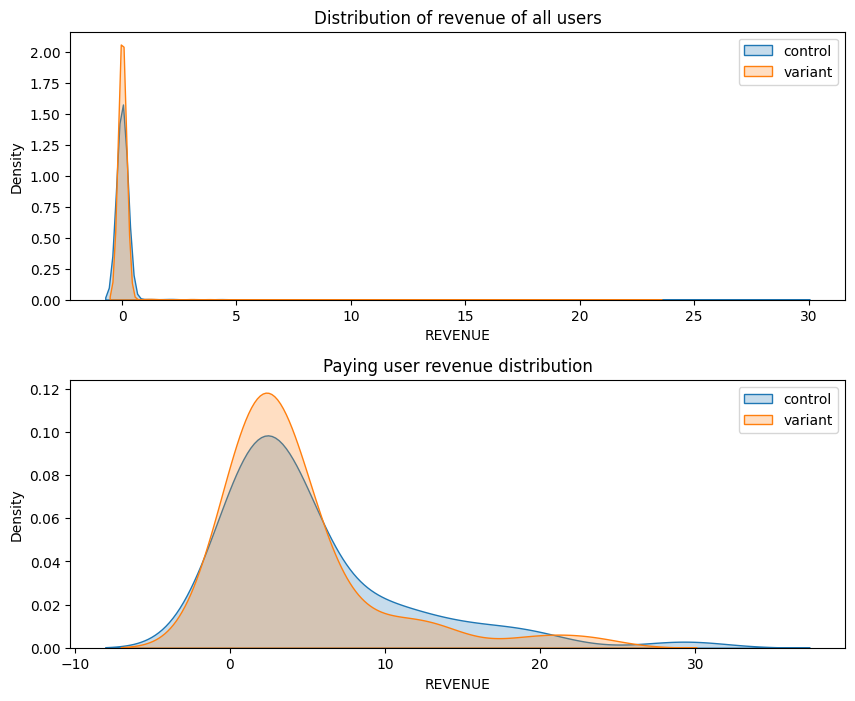

In [ ]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.kdeplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control', fill=True)
sns.kdeplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant', fill=True)
axes[0].set_title('Distribution of revenue of all users')
axes[0].legend()

# build graphs of distributions of paying users
sns.kdeplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control', fill=True)
sns.kdeplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant', fill=True)
axes[1].set_title('Paying user revenue distribution')
axes[1].legend()
plt.subplots_adjust(hspace = 0.3)
plt.show()

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

# Aggregate revenue per user (if not defined yet)
user_revenue_summary = df.groupby(["USER_ID", "VARIANT_NAME"])["REVENUE"].sum().reset_index()

from scipy.stats import shapiro

# Test on all users revenue
stat, p_value = shapiro(user_revenue_summary['REVENUE'])
print(f"Shapiro-Wilk test for all users: p-value = {p_value:.6f}")

# Test on paying users revenue
paying_users = user_revenue_summary[user_revenue_summary['REVENUE'] > 0]
stat_paid, p_value_paid = shapiro(paying_users['REVENUE'])
print(f"Shapiro-Wilk test for paying users: p-value = {p_value_paid:.6f}")



Shapiro-Wilk test for all users: p-value = 0.000000
Shapiro-Wilk test for paying users: p-value = 0.000000


Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [ ]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,4687
False,95


In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

from scipy.stats import mannwhitneyu

control_all = user_revenue_summary[user_revenue_summary['VARIANT_NAME'] == 'control']['REVENUE']
variant_all = user_revenue_summary[user_revenue_summary['VARIANT_NAME'] == 'variant']['REVENUE']

stat_mw_all, p_mw_all = mannwhitneyu(control_all, variant_all, alternative='two-sided')
print(f"Mann-Whitney test for all users: p-value = {p_mw_all:.6f}")



Mann-Whitney test for all users: p-value = 0.247996


In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney testpaying_users = user_revenue_summary[user_revenue_summary['REVENUE'] > 0]

control_paid = paying_users[paying_users['VARIANT_NAME'] == 'control']['REVENUE']
variant_paid = paying_users[paying_users['VARIANT_NAME'] == 'variant']['REVENUE']

stat_mw_paid, p_mw_paid = mannwhitneyu(control_paid, variant_paid, alternative='two-sided')
print(f"Mann-Whitney test for paying users: p-value = {p_mw_paid:.6f}")




Mann-Whitney test for paying users: p-value = 0.531419


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

all_samples = get_bootstrap_samples(user_revenue_summary['REVENUE'].values)


In [ ]:
# TODO : Generate samples for only paying users

def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

all_samples = get_bootstrap_samples(user_revenue_summary['REVENUE'].values)


Let's look at the distribution of means in the ab test groups

NameError: name 'control' is not defined

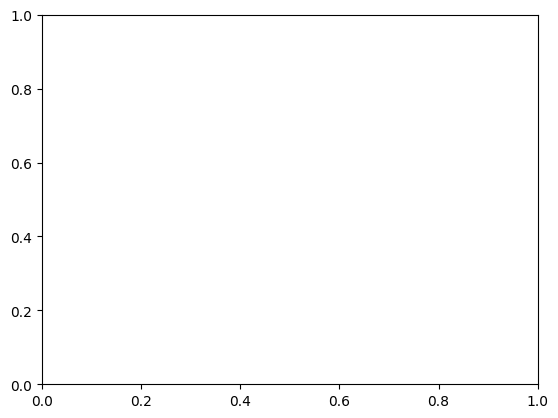

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

/tmp/ipython-input-51-3869574188.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_paid_samples, axis=1), shade=True, label='control')
/tmp/ipython-input-51-3869574188.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_paid_samples, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for paying users')

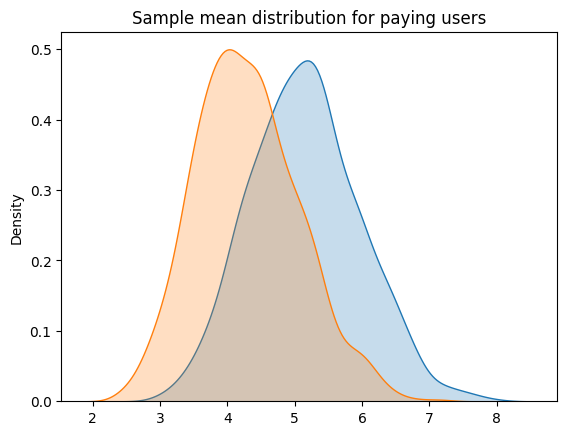

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))

# Regenerate bootstrap samples for paying users within this cell
control_paid_samples = get_bootstrap_samples(control_revenue_paid.values)
variant_paid_samples = get_bootstrap_samples(variant_revenue_paid.values)

sns.kdeplot(np.mean(control_paid_samples, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid_samples, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

Could not generate KDE plot for all users. This may be due to low variability in the data.


/tmp/ipython-input-50-4111737823.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()


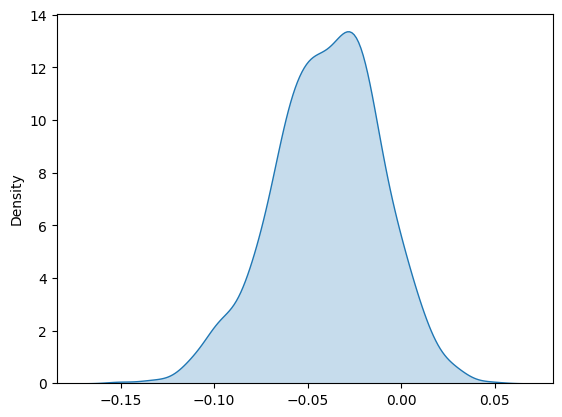

In [ ]:
# Regenerate bootstrap samples for all users within this cell
control_all_samples = get_bootstrap_samples(control_revenue_all.values)
variant_all_samples = get_bootstrap_samples(variant_revenue_all.values)

try:
    plot_distribution_and_stat_intervals(np.mean(variant_all_samples, axis=1),
                                         np.mean(control_all_samples, axis=1),
                                         title='all users')
except IndexError:
    print("Could not generate KDE plot for all users. This may be due to low variability in the data.")
    # Optionally, you could try plotting a histogram here instead
    # plt.figure()
    # sns.histplot(np.mean(variant_all_samples, axis=1) - np.mean(control_all_samples, axis=1), kde=True)
    # plt.title('Distribution of difference between means (variant - control) all users')
    # plt.show()

Could not generate KDE plot for paying users. This may be due to low variability in the data.


/tmp/ipython-input-50-4111737823.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()


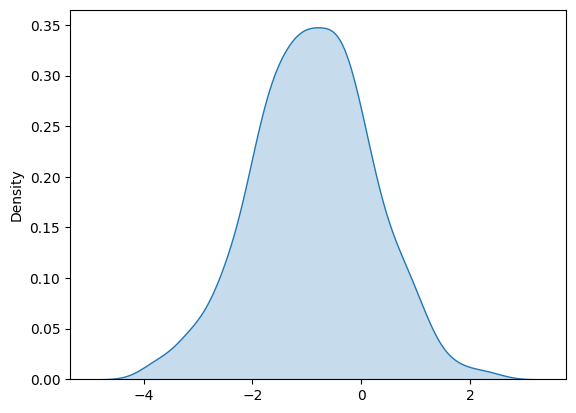

In [ ]:
# Regenerate bootstrap samples for paying users within this cell
control_paid_samples = get_bootstrap_samples(control_revenue_paid.values)
variant_paid_samples = get_bootstrap_samples(variant_revenue_paid.values)

try:
    plot_distribution_and_stat_intervals(np.mean(variant_paid_samples, axis=1),
                                         np.mean(control_paid_samples, axis=1),
                                         title='paying users')
except IndexError:
    print("Could not generate KDE plot for paying users. This may be due to low variability in the data.")
    # Optionally, you could try plotting a histogram here instead
    # plt.figure()
    # sns.histplot(np.mean(variant_paid_samples, axis=1) - np.mean(control_paid_samples, axis=1), kde=True)
    # plt.title('Distribution of difference between means (variant - control) paying users')
    # plt.show()

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.


In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
control_revenue_all = df[df['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue_all = df[df['VARIANT_NAME'] == 'variant']['REVENUE']

mw_stat_all, mw_p_value_all = mannwhitneyu(control_revenue_all, variant_revenue_all)

print(f"Mann-Whitney U test for all users:")
print(f"Statistic: {mw_stat_all:.4f}")
print(f"P-value: {mw_p_value_all:.6f}")

Mann-Whitney U test for all users:
Statistic: 2871768.0000
P-value: 0.247996


In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
control_revenue_paid = paying_users_df[paying_users_df['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue_paid = paying_users_df[paying_users_df['VARIANT_NAME'] == 'variant']['REVENUE']

mw_stat_paid, mw_p_value_paid = mannwhitneyu(control_revenue_paid, variant_revenue_paid)

print(f"Mann-Whitney U test for paying users:")
print(f"Statistic: {mw_stat_paid:.4f}")
print(f"P-value: {mw_p_value_paid:.6f}")

Mann-Whitney U test for paying users:
Statistic: 1197.0000
P-value: 0.531419
